<a href="https://colab.research.google.com/github/yoshimelaine/learn/blob/master/chembl_data_collection_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
#install anaconda and rdkit
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
! conda install -c rdkit rdkit -y
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/') 

--2020-06-26 16:24:25--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.130.3, 104.16.131.3, 2606:4700::6810:8303, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.130.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85055499 (81M) [application/x-sh]
Saving to: ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh’

Miniconda3-py37_4.8 100%[===================>]  81.12M   234MB/s    in 0.3s    

2020-06-26 16:24:25 (234 MB/s) - ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh’ saved [85055499/85055499]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: - \ done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - asn1crypto==1.3.0=py37_0
    - ca-certificates==2020.1.1=0
    - certifi==2019.11.28=py37_0
    - cffi==1.14.0=py37h2e261b9_0
    - chardet==3.0.4=py37_1003
    - conda-package-handling==1.6.0=py37h

In [4]:
import pandas as pd

In [5]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [6]:
df = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Data/bioactivity-data-preprocessed.csv') #load data

In [7]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

**calculate descriptors**

Lipinski's rules: 
- MW < 500 dalton
- LogP < 5
- HBD < 5
- HBA < 10

In [9]:
def lipinski(smiles, verbose=False):
  moldata = []
  for element in smiles:
    mol = Chem.MolFromSmiles(element)
    moldata.append(mol)

  baseData = np.arange(1,1)
  i = 0
  for mol in moldata:
    MW = Descriptors.MolWt(mol)
    LogP = Descriptors.MolLogP(mol)
    HBD = Lipinski.NumHDonors(mol)
    HBA = Lipinski.NumHAcceptors(mol)

    row = np.array([MW, LogP, HBD, HBA])

    if (i==0):
      baseData = row
    else:
      baseData = np.vstack([baseData, row])
    i=i+1

  column_titles = ["MW", "LogP", "HBD", "HBA"]
  desciptors = pd.DataFrame(data=baseData, columns=column_titles)

  return desciptors

In [10]:
df_lipinski = lipinski(df.canonical_smiles)

In [12]:
df_lipinski

,MW,LogP,HBD,HBA
0,281.271,1.89262,0.0,5.0
1,415.589,3.81320,0.0,2.0
2,421.190,2.66050,0.0,4.0
3,293.347,3.63080,0.0,3.0
4,338.344,3.53900,0.0,5.0
...,...,...,...,...
128,338.359,3.40102,0.0,5.0
129,296.366,3.44330,0.0,3.0
130,276.291,4.09564,0.0,3.0
131,278.307,3.29102,0.0,3.0


In [13]:
df

,molecule_chembl_id,canonical_smiles,standard_value,bioactivity_class
0,CHEMBL187579,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,7200.0,intermediate
1,CHEMBL188487,O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21,9400.0,intermediate
2,CHEMBL185698,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,13500.0,inactive
3,CHEMBL426082,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,13110.0,inactive
4,CHEMBL187717,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c1cccc2[N+](=O)[O-],2000.0,intermediate
...,...,...,...,...
128,CHEMBL2146517,COC(=O)[C@@]1(C)CCCc2c1ccc1c2C(=O)C(=O)c2c(C)c...,10600.0,inactive
129,CHEMBL187460,C[C@H]1COC2=C1C(=O)C(=O)c1c2ccc2c1CCCC2(C)C,10100.0,inactive
130,CHEMBL363535,Cc1coc2c1C(=O)C(=O)c1c-2ccc2c(C)cccc12,11500.0,inactive
131,CHEMBL227075,Cc1cccc2c3c(ccc12)C1=C(C(=O)C3=O)[C@@H](C)CO1,10700.0,inactive


In [14]:
df_full = pd.concat([df,df_lipinski], axis=1)
df_full

,molecule_chembl_id,canonical_smiles,standard_value,bioactivity_class,MW,LogP,HBD,HBA
0,CHEMBL187579,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,7200.0,intermediate,281.271,1.89262,0.0,5.0
1,CHEMBL188487,O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21,9400.0,intermediate,415.589,3.81320,0.0,2.0
2,CHEMBL185698,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,13500.0,inactive,421.190,2.66050,0.0,4.0
3,CHEMBL426082,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,13110.0,inactive,293.347,3.63080,0.0,3.0
4,CHEMBL187717,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c1cccc2[N+](=O)[O-],2000.0,intermediate,338.344,3.53900,0.0,5.0
...,...,...,...,...,...,...,...,...
128,CHEMBL2146517,COC(=O)[C@@]1(C)CCCc2c1ccc1c2C(=O)C(=O)c2c(C)c...,10600.0,inactive,338.359,3.40102,0.0,5.0
129,CHEMBL187460,C[C@H]1COC2=C1C(=O)C(=O)c1c2ccc2c1CCCC2(C)C,10100.0,inactive,296.366,3.44330,0.0,3.0
130,CHEMBL363535,Cc1coc2c1C(=O)C(=O)c1c-2ccc2c(C)cccc12,11500.0,inactive,276.291,4.09564,0.0,3.0
131,CHEMBL227075,Cc1cccc2c3c(ccc12)C1=C(C(=O)C3=O)[C@@H](C)CO1,10700.0,inactive,278.307,3.29102,0.0,3.0


convert IC50 to pIC50 (remove standard_value column, replaced my pIC50, multiplying the value by 10^-9

In [15]:
import numpy as np

def pIC50(input):
    pIC50 = []

    for i in input['standard_value_norm']:
        molar = i*(10**-9) # Converts nM to M
        pIC50.append(-np.log10(molar))

    input['pIC50'] = pIC50
    x = input.drop('standard_value_norm', 1)
        
    return x

In [16]:
df_full.standard_value.describe()

count    1.330000e+02
mean     8.017926e+12
std      3.344888e+13
min      5.000000e+01
25%      1.070000e+04
50%      2.350000e+04
75%      3.000000e+05
max      3.311311e+14
Name: standard_value, dtype: float64

In [17]:
def norm_value(input):
    norm = []

    for i in input['standard_value']:
        if i > 100000000:
          i = 100000000
        norm.append(i)

    input['standard_value_norm'] = norm
    x = input.drop('standard_value', 1)
        
    return x

In [18]:
df_norm = norm_value(df_full) #normalize the value in standard_value column
df_norm

,molecule_chembl_id,canonical_smiles,bioactivity_class,MW,LogP,HBD,HBA,standard_value_norm
0,CHEMBL187579,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,intermediate,281.271,1.89262,0.0,5.0,7200.0
1,CHEMBL188487,O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21,intermediate,415.589,3.81320,0.0,2.0,9400.0
2,CHEMBL185698,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,inactive,421.190,2.66050,0.0,4.0,13500.0
3,CHEMBL426082,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,inactive,293.347,3.63080,0.0,3.0,13110.0
4,CHEMBL187717,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c1cccc2[N+](=O)[O-],intermediate,338.344,3.53900,0.0,5.0,2000.0
...,...,...,...,...,...,...,...,...
128,CHEMBL2146517,COC(=O)[C@@]1(C)CCCc2c1ccc1c2C(=O)C(=O)c2c(C)c...,inactive,338.359,3.40102,0.0,5.0,10600.0
129,CHEMBL187460,C[C@H]1COC2=C1C(=O)C(=O)c1c2ccc2c1CCCC2(C)C,inactive,296.366,3.44330,0.0,3.0,10100.0
130,CHEMBL363535,Cc1coc2c1C(=O)C(=O)c1c-2ccc2c(C)cccc12,inactive,276.291,4.09564,0.0,3.0,11500.0
131,CHEMBL227075,Cc1cccc2c3c(ccc12)C1=C(C(=O)C3=O)[C@@H](C)CO1,inactive,278.307,3.29102,0.0,3.0,10700.0


In [19]:
df_final = pIC50(df_norm)
df_final

,molecule_chembl_id,canonical_smiles,bioactivity_class,MW,LogP,HBD,HBA,pIC50
0,CHEMBL187579,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,intermediate,281.271,1.89262,0.0,5.0,5.142668
1,CHEMBL188487,O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21,intermediate,415.589,3.81320,0.0,2.0,5.026872
2,CHEMBL185698,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,inactive,421.190,2.66050,0.0,4.0,4.869666
3,CHEMBL426082,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,inactive,293.347,3.63080,0.0,3.0,4.882397
4,CHEMBL187717,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c1cccc2[N+](=O)[O-],intermediate,338.344,3.53900,0.0,5.0,5.698970
...,...,...,...,...,...,...,...,...
128,CHEMBL2146517,COC(=O)[C@@]1(C)CCCc2c1ccc1c2C(=O)C(=O)c2c(C)c...,inactive,338.359,3.40102,0.0,5.0,4.974694
129,CHEMBL187460,C[C@H]1COC2=C1C(=O)C(=O)c1c2ccc2c1CCCC2(C)C,inactive,296.366,3.44330,0.0,3.0,4.995679
130,CHEMBL363535,Cc1coc2c1C(=O)C(=O)c1c-2ccc2c(C)cccc12,inactive,276.291,4.09564,0.0,3.0,4.939302
131,CHEMBL227075,Cc1cccc2c3c(ccc12)C1=C(C(=O)C3=O)[C@@H](C)CO1,inactive,278.307,3.29102,0.0,3.0,4.970616


In [20]:
df_2class = df_final[df_final.bioactivity_class != 'intermediate'] #remove intermediate class
df_2class

,molecule_chembl_id,canonical_smiles,bioactivity_class,MW,LogP,HBD,HBA,pIC50
2,CHEMBL185698,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,inactive,421.190,2.66050,0.0,4.0,4.869666
3,CHEMBL426082,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,inactive,293.347,3.63080,0.0,3.0,4.882397
5,CHEMBL365134,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c(Br)cccc21,active,372.243,4.39330,0.0,3.0,6.008774
7,CHEMBL190743,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccc(I)cc21,active,419.243,4.23540,0.0,3.0,6.022276
8,CHEMBL365469,O=C1C(=O)N(Cc2cc3ccccc3s2)c2cccc(Cl)c21,inactive,327.792,4.28420,0.0,3.0,4.950782
...,...,...,...,...,...,...,...,...
128,CHEMBL2146517,COC(=O)[C@@]1(C)CCCc2c1ccc1c2C(=O)C(=O)c2c(C)c...,inactive,338.359,3.40102,0.0,5.0,4.974694
129,CHEMBL187460,C[C@H]1COC2=C1C(=O)C(=O)c1c2ccc2c1CCCC2(C)C,inactive,296.366,3.44330,0.0,3.0,4.995679
130,CHEMBL363535,Cc1coc2c1C(=O)C(=O)c1c-2ccc2c(C)cccc12,inactive,276.291,4.09564,0.0,3.0,4.939302
131,CHEMBL227075,Cc1cccc2c3c(ccc12)C1=C(C(=O)C3=O)[C@@H](C)CO1,inactive,278.307,3.29102,0.0,3.0,4.970616


**chemical space analysis via lipinski descriptors**

In [21]:
import seaborn as sns
sns.set(style='ticks')
import matplotlib.pyplot as plt

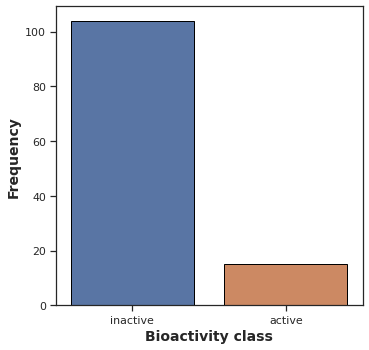

In [22]:
#frequency plot of 2 classes
plt.figure(figsize=(5.5, 5.5))

sns.countplot(x='bioactivity_class', data=df_2class, edgecolor='black')

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')

plt.savefig('plot_bioactivity_class.pdf')

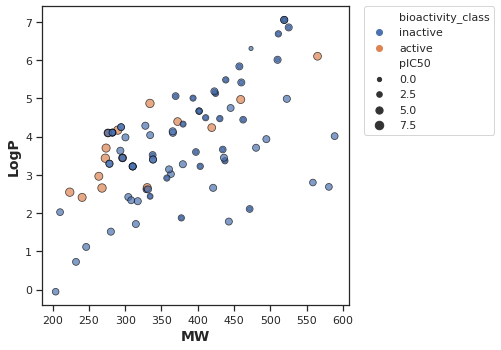

In [23]:
#scatter plot of MW vs LogP

plt.figure(figsize=(5.5, 5.5))

sns.scatterplot(x='MW', y='LogP', data=df_2class, hue='bioactivity_class', size='pIC50', edgecolor='black', alpha=0.7)

plt.xlabel('MW', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.savefig('plot_MW_vs_LogP.pdf')

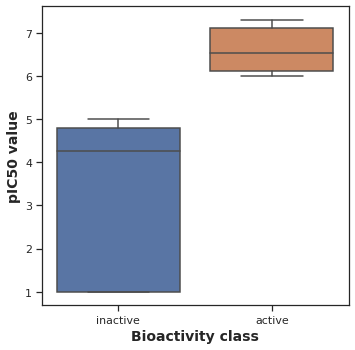

In [24]:
#pIC50 value

plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'pIC50', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('pIC50 value', fontsize=14, fontweight='bold')

plt.savefig('plot_ic50.pdf')

In [25]:
#Mann-Whitney U Test

def mannwhitney(descriptor, verbose=False):
  from numpy.random import seed
  from numpy.random import randn
  from scipy.stats import mannwhitneyu

#seed the random number generator
  seed(1)

#actives and inactives
  selection = [descriptor, 'bioactivity_class']
  df = df_2class[selection]
  active = df[df.bioactivity_class == 'active']
  active = active[descriptor]

  selection = [descriptor, 'bioactivity_class']
  df = df_2class[selection]
  inactive = df[df.bioactivity_class == 'inactive']
  inactive = inactive[descriptor]

#compare samples
  stat, p = mannwhitneyu(active, inactive)
  #print('Statistics=%.3f, p=%.3f' % (stat, p))

#interpret
  alpha = 0.05
  if p > alpha:
    interpretation = 'Same distribution (fail to reject H0)'
  else:
    interpretation = 'Different distribution (reject H0)'
  
  results = pd.DataFrame({'Descriptor':descriptor,
                          'Statistics':stat,
                          'p':p,
                          'alpha':alpha,
                          'Interpretation':interpretation}, index=[0])
  filename = 'mannwhitneyu_' + descriptor + '.csv'
  results.to_csv(filename)

  return results

In [26]:
mannwhitney('pIC50')

,Descriptor,Statistics,p,alpha,Interpretation
0,pIC50,0.0,1.662636e-10,0.05,Different distribution (reject H0)


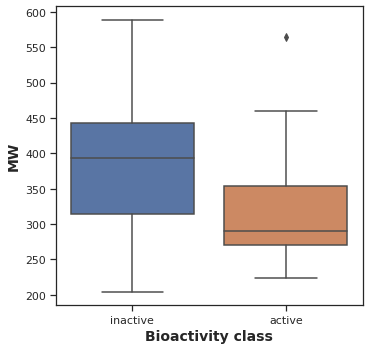

In [27]:
#MW

plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'MW', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('MW', fontsize=14, fontweight='bold')

plt.savefig('plot_MW.pdf')

In [28]:
mannwhitney('MW')

,Descriptor,Statistics,p,alpha,Interpretation
0,MW,409.5,0.001525,0.05,Different distribution (reject H0)


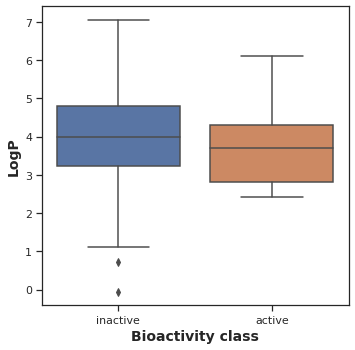

In [29]:
#LogP

plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'LogP', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')

plt.savefig('plot_LogP.pdf')

In [30]:
mannwhitney('LogP')

,Descriptor,Statistics,p,alpha,Interpretation
0,LogP,712.5,0.295805,0.05,Same distribution (fail to reject H0)


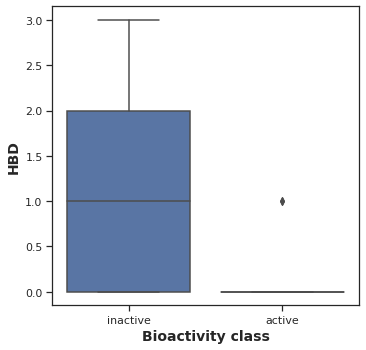

In [32]:
#HBD

plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'HBD', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('HBD', fontsize=14, fontweight='bold')

plt.savefig('plot_HBD.pdf')

In [33]:
mannwhitney('HBD')

,Descriptor,Statistics,p,alpha,Interpretation
0,HBD,299.5,0.000024,0.05,Different distribution (reject H0)


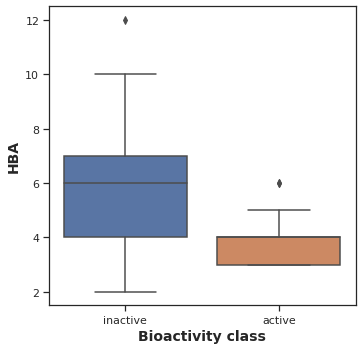

In [34]:
#HBA

plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'HBA', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('HBA', fontsize=14, fontweight='bold')

plt.savefig('plot_HBA.pdf')

In [35]:
mannwhitney('HBA')

,Descriptor,Statistics,p,alpha,Interpretation
0,HBA,415.0,0.001557,0.05,Different distribution (reject H0)


In [36]:
#compress the files
! zip -r results.zip . -i *.csv *.pdf

  adding: plot_MW.pdf (deflated 38%)
  adding: plot_bioactivity_class.pdf (deflated 38%)
  adding: mannwhitneyu_LogP.csv (deflated 7%)
  adding: plot_HBA.pdf (deflated 38%)
  adding: plot_MW_vs_LogP.pdf (deflated 15%)
  adding: plot_ic50.pdf (deflated 37%)
  adding: plot_LogP.pdf (deflated 37%)
  adding: plot_HBD.pdf (deflated 39%)
  adding: mannwhitneyu_HBA.csv (deflated 10%)
  adding: mannwhitneyu_pIC50.csv (deflated 10%)
  adding: mannwhitneyu_HBD.csv (deflated 9%)
  adding: mannwhitneyu_MW.csv (deflated 9%)


In [37]:
#save result

! cp results.zip "/content/gdrive/My Drive/Colab Notebooks/Data"